In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [1]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res

HouseData = LoadHouse()
NofAlgorithms = 9
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])

for baseline in xrange(10,101,10):



    Accuracy = np.zeros([NofAlgorithms, end - baseline])
    Rtime = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])




    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,1])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True)
        G2 = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False)
        Gvis = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True)
        G.SetVerbose(False)

        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        res2 = FB.BaBSolver(G2, 30, 10, 0.005, False)


        resBag = eng.runBcagm(nargout=3)
        resBagMP = eng.runBcagmQuad1(1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(2,nargout=3)
        resHGM = eng.runHGM(nargout=3)
        resRRWHM = eng.runRRWHM(nargout=3)
        resTM = eng.runTensorMatching(nargout=3)



        start_time = time.time()
        ResForBca = sio.loadmat('Temp.mat')
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat('Temp.mat', ResForBca)
        resOursBCA = eng.runBcagm(nargout=3)
        time_dur = time.time() - start_time

        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if(res1.Value < Gvis.ComputeObj(cDecode)):
            Accuracy[8][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, NofNodes)
            Obj[8][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            Accuracy[8][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
            Obj[8][ImageI] = res1.Value



        Rtime[8][ImageI] = time_dur + res1.Time


        Accuracy[0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value

        Accuracy[7][ImageI] = ComputeAccurancy(res2.Decode, gTruth, NofNodes)
        Rtime[7][ImageI] = res2.Time
        Obj[7][ImageI] = res2.Value

        Accuracy[1][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, NofNodes)
        Rtime[1][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[2][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, NofNodes)
        Rtime[2][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[3][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, NofNodes)
        Rtime[3][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)


        Accuracy[4][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, NofNodes)
        Rtime[4][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)


        Accuracy[5][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, NofNodes)
        Rtime[5][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[6][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, NofNodes)
        Rtime[6][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)

        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj

        for ai in xrange(NofAlgorithms):
            print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                             Accuracy[ai][ImageI],
                                                            Rtime[ai][ImageI],
                                                            Obj[ai][ImageI]))
        print(' Finished Frame: %d' % (ImageI) )
    
    #Todo Ours-BCA
    for ni in range(Obj.shape[1]):
        MaxObj = np.max(Obj[:,ni])
        Obj[:,ni] /= MaxObj
    
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(Accuracy[ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(Rtime[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
    
    

NameError: global name 'np' is not defined

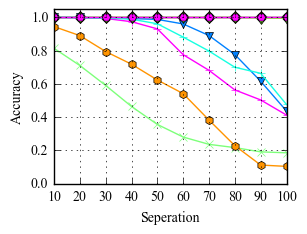

In [28]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline


Colors = [[ 0.        ,  0.5        , 0.5        ,  1.        ],
          [ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],
          [ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ]];
Seq = [7, 0, 1, 2, 3, 4, 5, 6, 8]
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
Markers = ['o', '+', 'v', '+', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(3, 2.25), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

In [29]:
StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('PlotData.mat', StoreForPlot)

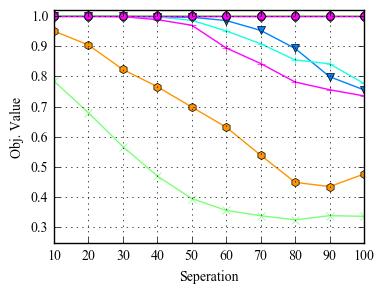

In [30]:
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'OursPW'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('House_Obj.pdf')    # <-- loses transparency

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')




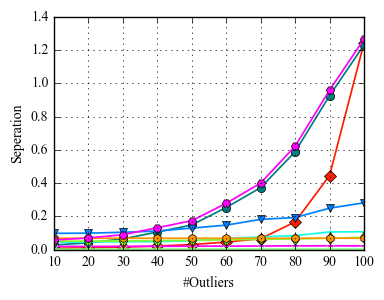

In [31]:


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('Car_Time.pdf')    # <-- loses transparency

In [24]:
MeanAcc[:,0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [33]:
G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)




BaBIter=1, GUB = 100000000000000000000.000000, GLB = -100000000000000000000.000000, Gap = 2.00, Time=0.2970
BaBIter=2, GUB = 100000000000000000000.000000, GLB = 165.399185, Gap = 604597900822120832.00, Time=0.3050
BaBIter=3, GUB = 174.231906, GLB = 165.399185, Gap = 0.05, Time=0.3136
BaBIter=4, GUB = 174.231906, GLB = 165.399185, Gap = 0.05, Time=0.3205
BaBIter=5, GUB = 174.155314, GLB = 165.399185, Gap = 0.05, Time=0.3294
BaBIter=6, GUB = 174.155314, GLB = 165.399185, Gap = 0.05, Time=0.3388
BaBIter=7, GUB = 173.871366, GLB = 165.399185, Gap = 0.05, Time=0.3477
BaBIter=8, GUB = 173.871366, GLB = 165.399185, Gap = 0.05, Time=0.3571
BaBIter=9, GUB = 173.749295, GLB = 165.399185, Gap = 0.05, Time=0.3647
BaBIter=10, GUB = 173.749295, GLB = 165.399185, Gap = 0.05, Time=0.3736
BaBIter=11, GUB = 173.626528, GLB = 165.399185, Gap = 0.05, Time=0.3838
BaBIter=12, GUB = 173.626528, GLB = 165.399185, Gap = 0.05, Time=0.3924
BaBIter=13, GUB = 173.271952, GLB = 165.399185, Gap = 0.05, Time=0.4025
B